In [2]:
import uproot as up
import awkward as ak
import pandas as pd
from scipy.optimize import curve_fit

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
from pathlib import Path

import mplhep as hep
hep.style.use('ROOT')

In [29]:
class Event:
    def __init__(self, time_since_last_trigger_us, timestamp_us, nhits, 
                 digit_pmt_id, digit_charge_pc, total_digit_charge_pc, digit_time_ns, digit_ncrossings, 
                 log_pmt_id, log_charge_pc, total_log_charge_pc, log_time_ns,
                 gaussian_pmt_id, gaussian_charge_pc, total_gaussian_charge_pc, gaussian_time_ns,
                 xquad, yquad, zquad): 
        # Global event data
        self.time_since_last_trigger_us = time_since_last_trigger_us
        self.timestamp_us = timestamp_us
        self.nhits = nhits
        self.total_digit_charge_pc = total_digit_charge_pc # ***BROKEN*** 
        self.total_log_charge_pc = total_log_charge_pc # ***BROKEN*** 
        self.total_gaussian_charge_pc = total_gaussian_charge_pc # USE THIS ONE
        self.trigger_type = None # 0=prompt 1=follower
        self.time_since_last_prompt_trigger_us = None

        # Arrays with PMT information 
        self.digit_pmt_id = digit_pmt_id # id of every pmt hit 
        self.digit_ncrossings = digit_ncrossings # number of crossings for every pmt hit 
        self.digit_time_ns = digit_time_ns # time of first crossing for every pmt hit
        self.digit_charge_pc = digit_charge_pc # ***BROKEN*** total charge for every pmt hit
        self.log_pmt_id = log_pmt_id 
        self.log_charge_pc = log_charge_pc # ***BROKEN*** total charge for every pmt hit 
        self.log_time_ns = log_time_ns 
        self.gaussian_pmt_id = gaussian_pmt_id
        self.gaussian_charge_pc = gaussian_charge_pc
        self.gaussian_time_ns = gaussian_time_ns
        self.xquad = xquad
        self.yquad = yquad
        self.zquad = zquad



    def print(self):
        print("---------------------------------------")
        print(f"                     Timestamp : {self.timestamp_us:.3f} us")
        print(f"       Time since last trigger : {self.time_since_last_trigger_us:.3f} us ")
        print(f"                  Trigger Type : {self.trigger_type}")
        print(f"Time since last prompt trigger : {self.time_since_last_prompt_trigger_us}")
        print(f"                         NHits : {self.nhits}")


class Run:
    def __init__(self,number):
        # Run data
        self.number = number 
        self.files = []

        # Meta data (non event dependent)
        self.pmt_type = None
        self.pmt_id = None
        self.pmt_ch = None
        self.pmt_is_online = None
        self.pmt_cable_offset = None

        # Event data
        self.events = []

    # Load data for the run
    def load_files(self, path):
        path = Path(path)
        files = list(path.glob("*/*.root"))
        for f in files:
            if f"run{self.number}" in f.as_posix():
                self.files.append(f)
        #print(self.files)
        #self.files = sorted(self.files, key=lambda x: int(x.stem.split('_')[3].split('.')[0]))
        print(f"Found {len(self.files)} files for run {self.number}")
        #self.files=self.files[:5]

    # Can open any one of the run files to get this
    def load_meta_data(self):
        f=up.open(self.files[0])
        print(f['meta'].keys())

        # self.pmt_type = f['meta']['pmtType'].array(library='np')[0]
        # self.pmt_id = f['meta']['pmtId'].array(library='np')[0]
        # self.pmt_ch = f['meta']['pmtChannel'].array(library='np')[0]
        # self.pmt_is_online = f['meta']['pmtIsOnline'].array(library='np')[0]
        # self.pmt_cable_offset = f['meta']['pmtCableOffset'].array(library='np')[0]

    # Must open all the files (assume events in file are in order - timestamp is just wrong)
    def load_event_data(self):
        last_file_end_timestamp_us = 0 # for continuity across files

        for file in tqdm(self.files, desc=f"Parsing {len(self.files)} files for run {self.number}", colour='green'):
            f=up.open(file)
            print(f['events'].keys())

            # # Per pmt
            # digit_pmt_id = f['output']['digitPMTID'].array(library='ak')
            # digit_charge_pc = f['output']['digitCharge'].array(library='ak')
            # digit_time_ns = f['output']['digitTime'].array(library='ak')
            # digit_ncrossings = f['output']['digitNCrossings'].array(library='ak')
            # log_pmt_id = f['output']['fit_pmtid_Lognormal'].array(library='ak')
            # log_charge_pc = f['output']['fit_charge_Lognormal'].array(library='ak')
            # log_time = f['output']['fit_time_Lognormal'].array(library='ak')
            # gaussian_pmt_id = f['output']['fit_pmtid_Gaussian'].array(library='ak')
            # gaussian_charge_pc = f['output']['fit_charge_Gaussian'].array(library='ak')
            # gaussian_time = f['output']['fit_time_Gaussian'].array(library='ak')

            # # Per event
            # time_since_last_trigger_us = f['output']['timeSinceLastTrigger_us'].array(library='ak') # Make timestamp using relative trigger times
            # time_since_last_trigger_us = ak.to_numpy(time_since_last_trigger_us)  # Convert to NumPy array
            # time_since_last_trigger_us[time_since_last_trigger_us > 1e6] = 10000 # Replace large values with 0.01 s
            # time_since_last_trigger_us[time_since_last_trigger_us < 0] = 10000 # Replace negative values with 0.01 s

            # timestamp_us = np.cumsum(time_since_last_trigger_us) + last_file_end_timestamp_us
            # last_file_end_timestamp_us = timestamp_us[-1]
            
            # nhits = f['output']['digitNhits'].array(library='ak')

            # xquad = f['output']['x_quadfitter'].array(library='ak')
            # yquad = f['output']['y_quadfitter'].array(library='ak')
            # zquad= f['output']['z_quadfitter'].array(library='ak')

            # # # Clean up digit charges
            # #digit_charge_pc = ak.where(digit_charge_pc < 0, 0, digit_charge_pc)  # Replace negative values with 0
            # digit_charge_pc = digit_charge_pc[digit_charge_pc >=0]
            # # #digit_charge_pc = ak.to_numpy(digit_charge_pc)
            # # for i in range(len(digit_charge_pc)):
            # #     for j in range(len(digit_charge_pc[i])):
            # #         if digit_charge_pc[i][j]<0:
            # #             digit_charge_pc[i][j]=0

            # total_digit_charge_pc = np.sum(digit_charge_pc, axis=1)
            # total_log_charge_pc = np.sum(log_charge_pc, axis=1)
            # total_gaussian_charge_pc = np.sum(gaussian_charge_pc, axis=1)

            
            # # Create event instances
            # for i in range(len(nhits)):
            #     event = Event(
            #         time_since_last_trigger_us[i],
            #         timestamp_us[i],
            #         nhits[i],
            #         digit_pmt_id[i],
            #         digit_charge_pc[i],
            #         total_digit_charge_pc[i],
            #         digit_time_ns[i],
            #         digit_ncrossings[i],
            #         log_pmt_id[i],
            #         log_charge_pc[i],
            #         total_log_charge_pc[i],
            #         log_time[i],
            #         gaussian_pmt_id[i],
            #         gaussian_charge_pc[i],
            #         total_gaussian_charge_pc[i],
            #         gaussian_time[i],
            #         xquad[i],
            #         yquad[i],
            #         zquad[i],
            #     )
            #     self.events.append(event)

    def reset_trigger_types(self):
        for event in self.events:
            event.trigger_type = None

    def set_trigger_types_with_nhit(self,prompt_nhit_range, follower_nhit_range):
        for event in self.events:
            if prompt_nhit_range[0] <= event.nhits < prompt_nhit_range[1]:
                event.trigger_type = 0 
            elif follower_nhit_range[0] < event.nhits < follower_nhit_range[1]:
                event.trigger_type = 1 
    
    def set_trigger_types_with_nhit_and_charge(self, prompt_nhit_range, follower_nhit_range, prompt_charge_range):
        for event in self.events:
            # use charge to further distinguish prompts
            if prompt_nhit_range[0] <= event.nhits < prompt_nhit_range[1] and prompt_charge_range[0] <= event.total_gaussian_charge_pc < prompt_charge_range[1]:
                event.trigger_type = 0 
            elif follower_nhit_range[0] < event.nhits < follower_nhit_range[1]:
                event.trigger_type = 1

    def set_trigger_types_with_nhit_and_charge_curve(self, curve):
        for event in self.events:
            nhit = event.nhits
            charge = event.total_gaussian_charge_pc
            if charge > curve(nhit):
                self.trigger_type = 0
            else:
                self.trigger_type = 1
            
    def set_time_since_last_promp_trigger(self):
        prompt_time = 0
        for event in self.events:
            if event.trigger_type==0:
                prompt_time = event.timestamp_us
            else:
                event.time_since_last_prompt_trigger_us = event.timestamp_us - prompt_time

    def reset_time_since_last_prompt_trigger(self):
        for event in self.events:
            event.time_since_last_prompt_trigger_us = None
                
    def get_time_since_last_trigger_us(self):
        return [event.time_since_last_trigger_us for event in self.events]

    def get_time_since_last_prompt_trigger_us(self):
        return [event.time_since_last_prompt_trigger_us for event in self.events]

    def get_timestamp_us(self):
        return [event.timestamp_us for event in self.events]
    
    def get_nhits(self):
        return [event.nhits for event in self.events]
    
    def get_digit_pmt_id(self):
        return [event.digit_pmt_id for event in self.events]
    
    def get_digit_charge_pc(self):
        return [event.digit_charge_pc for event in self.events]
    
    def get_total_digit_charge_pc(self):
        return [event.total_digit_charge_pc for event in self.events]
    
    def get_digit_time_ns(self):
        return [event.digit_time_ns for event in self.events]
    
    def get_digit_ncrossings(self):
        return [event.digit_ncrossings for event in self.events]
    
    def get_log_pmt_id(self):
        return [event.log_pmt_id for event in self.events]
    
    def get_log_charge_pc(self):
        return [event.log_charge_pc for event in self.events]
    
    def get_total_log_charge_pc(self):
        return [event.total_log_charge_pc for event in self.events]
    
    def get_log_time_ns(self):
        return [event.log_time_ns for event in self.events]
    


In [30]:
path = '/nfs/disk1/eos/data/water_fill/deployed_source/laserball/'
#path = '/nfs/disk1/users/bharris/eos/sim/EosSimulations/'

run = Run(149)
run.load_files(path)
run.load_meta_data()
run.load_event_data()

Found 1 files for run 149
['nfiles', 'pedestal_window', 'window_length', 'analysis_code_version', 'threshold', 'pmtx', 'pmty', 'pmtz']


Parsing 1 files for run 149: 100%|██████████| 1/1 [00:00<00:00, 24.26it/s]

['event_number', 'nhit', 'total_charge', 'deltat', 'channel', 'board', 'lcn', 'time', 'channel15_time', 'pedestal', 'charge', 'charge_short', 'ncrossings', 'pulse_height', 'fitted_pulse_height', 'trigger_time', 'fitted_time', 'chi2ndf']


In [11]:
def line(x,a,b,c):
    return np.exp(a*(x+b))+c

#first = line(x,0.022,108,90)


prompt_nhit_range = (185,200)
follower_nhit_range = (70,130)

prompt_charge_range = (600,1500)

run.reset_trigger_types()
run.reset_time_since_last_prompt_trigger()

run.set_trigger_types_with_nhit(prompt_nhit_range, follower_nhit_range)
#run.set_trigger_types_with_nhit_and_charge(prompt_nhit_range, follower_nhit_range, prompt_charge_range)
#run.set_trigger_types_with_nhit_and_charge_curve
run.set_time_since_last_promp_trigger()

nprompt = [event.trigger_type==0 for event in run.events].count(True)
print(f"{nprompt} prompt triggers found")
nfollower= [event.trigger_type==1 for event in run.events].count(True)
print(f"{nfollower} follower triggers found")
nbad = [event.trigger_type==None for event in run.events].count(True)
print(f"{nbad} bad triggers found")

nhits = run.get_nhits()
ts = run.get_timestamp_us()
dt = run.get_time_since_last_trigger_us()
dt_prompt = run.get_time_since_last_prompt_trigger_us()

prescale = 16
print(f"Got {ts[-1]/1e6:.3f} s of data")
print(f"Prompt trigger frequency {16*nprompt/(ts[-1]/1e6):.3f} Hz")
print(f"Follower trigger frequency {nfollower/(ts[-1]/1e6):.3f} Hz")


0 prompt triggers found
0 follower triggers found
0 bad triggers found


IndexError: list index out of range

In [12]:
charge = [event.total_log_charge_pc for event in run.events]
nhit = [event.nhits for event in run.events]

prompt_charge = [event.total_log_charge_pc for event in run.events if event.trigger_type==0]
prompt_nhit = [event.nhits for event in run.events if event.trigger_type==0]

early_follower_charge = [event.total_log_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us < 4]
early_follower_nhit = [event.nhits for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us < 4]

late_follower_charge = [event.total_log_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us >= 4]
late_follower_nhit = [event.nhits for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us >= 4]

x = np.linspace(0,200,100)

fig, ax = plt.subplots(1,4, figsize=(15,5))
fig.tight_layout()
hep.hist2dplot(np.histogram2d(nhits, charge, bins=(200,200), range=((0,200),(0,1500))), ax=ax[0], norm='log')
ax[0].set_title("All Triggers")
ax[0].plot(x,line(x,0.022,108,90),'-',linewidth=2,color='red')

hep.hist2dplot(np.histogram2d(prompt_nhit, prompt_charge, bins=(200,200), range=((0,200),(0,1500))), ax=ax[1], norm='log')
ax[1].set_title("Prompt Triggers")
ax[1].set_xlabel("NHits")
ax[1].set_ylabel("Charge (pc)")

hep.hist2dplot(np.histogram2d(early_follower_nhit, early_follower_charge, bins=(200,200), range=((0,200),(0,500))), ax=ax[2], norm='log')
ax[2].set_title("Early Follower Triggers")
ax[2].set_xlabel("NHits")   
ax[2].set_ylabel("Charge (pc)")

hep.hist2dplot(np.histogram2d(late_follower_nhit, late_follower_charge, bins=(200,200), range=((0,200),(0,500))), ax=ax[3], norm='log')
ax[3].set_title("Late Follower Triggers")
ax[3].set_xlabel("NHits")
ax[3].set_ylabel("Charge (pc)")

# Cut on nhit and charge aboce 100 nhit to isolate the three regions
# Top is prompt muons
# Bottoms is early michels
# What is middle? Late something

ValueError: Invalid vmin or vmax

Error in callback <function _draw_all_if_interactive at 0x7495b88b3af0> (for post_execute), with arguments args (),kwargs {}:


ValueError: Invalid vmin or vmax

ValueError: Invalid vmin or vmax

<Figure size 1605x500 with 5 Axes>

In [13]:
# early_total_charge = [event.total_gaussian_charge_pc for event in run.events if event.time_since_last_trigger_us<3]
# late_total_charge = [event.total_gaussian_charge_pc for event in run.events if event.time_since_last_trigger_us>3]

# ec, eb = np.histogram(early_total_charge, bins=50, range=(0,500))
# lc, lb = np.histogram(late_total_charge, bins=50, range=(0,500))
# res = lc-ec
# centers = (eb[1:]+eb[:-1])/2

# plt.hist(early_total_charge, bins=50, range=(0,500), histtype='step', label='Early - Decaying Muon');
# plt.hist(late_total_charge, bins=50, range=(0,500), histtype='step', label='Late - Crossing Muon');
# plt.plot(centers, res, label='Difference',)
# plt.legend()
# plt.yscale('log')

In [14]:
# for event in run.events:
#     event.print()

print(','.join(f"{bool}" for bool in run.pmt_is_online))


TypeError: 'NoneType' object is not iterable

/tmp/ipykernel_2808082/561893430.py:9: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


Text(1, 0, 'Total NHits per Event')

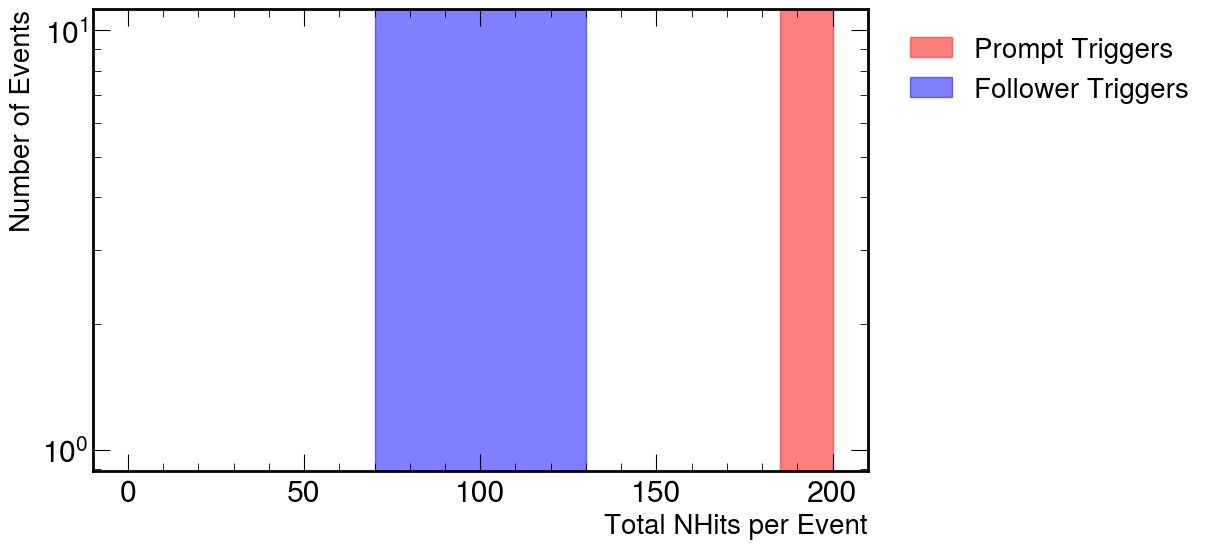

In [15]:
nhits = run.get_nhits()

plt.figure(figsize=(10, 6))
hep.histplot(np.histogram(nhits, bins=200, range=(0, 200)), color='black')
plt.axvspan(prompt_nhit_range[0], prompt_nhit_range[1], color='red', alpha=0.5, label='Prompt Triggers')
plt.axvspan(follower_nhit_range[0], follower_nhit_range[1], color='blue', alpha=0.5, label='Follower Triggers')
plt.legend(loc='upper right',bbox_to_anchor=(1.45, 1),fontsize=20)
#plt.ylim(1e3,1e5)
plt.yscale('log')
plt.ylabel('Number of Events', fontsize=20)
plt.xlabel('Total NHits per Event', fontsize=20)

In [16]:
ts_prompt = [event.timestamp_us for event in run.events if event.trigger_type==0]
ts_follower = [event.timestamp_us for event in run.events if event.trigger_type==1]
ts_bad = [event.timestamp_us for event in run.events if event.trigger_type==None]

deltat = [event.time_since_last_trigger_us for event in run.events if event.trigger_type==1]
deltat_follower = [event.time_since_last_prompt_trigger_us for event in run.events if event.trigger_type==1]
deltat_follower_early = [event.time_since_last_prompt_trigger_us for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us < 4]
print(len(deltat),len(deltat_follower))

nhits_prompt = [event.nhits for event in run.events if event.trigger_type==0]
nhits_follower = [event.nhits for event in run.events if event.trigger_type==1]
nhits_bad = [event.nhits for event in run.events if event.trigger_type==None]

fig, ax = plt.subplots(1,2,figsize=(25, 10))
fig.tight_layout()
ax[0].plot(ts_prompt, nhits_prompt, 'o', markersize=5, label='prompt', color='red')
ax[0].plot(ts_follower, nhits_follower, 'o', markersize=5, label='follower', color='blue')
ax[0].plot(ts_bad, nhits_bad, 'o', markersize=5, label='follower', color='black')
ax[0].set_xlabel('Timestamp (µs)', loc='center',fontsize=30)
ax[0].set_ylabel('Total NHits per Event', fontsize=30)
ax[0].set_xlim(0, 5e7)
ax[0].legend(loc='upper left',bbox_to_anchor=(-0.35, 1),fontsize=25)
#ax[1].plot(deltat_follower, nhits_follower, 'o', markersize=5, label='follower', color='blue')
hd = ax[1].hist2d(deltat_follower, nhits_follower, bins=(30, 30), range=((1, 20), (0,200)),norm='log', cmap='Blues')
ax[1].set_xlabel('Time Since Last Prompt Trigger (µs)', loc='center', fontsize=30)
ax[1].set_xlim(1,20)
#ax[1].set_ylim(follower_nhit_range[0], follower_nhit_range[1])  
fig.colorbar(hd[3],ax=ax[1])
#ax[2].plot(deltat, nhits_follower, 'o', markersize=5, label='follower', color='blue')
# hdf = ax[2].hist2d(deltat, nhits_follower, bins=(19, 20), range=((1, 20), (0, 200)), cmap='Blues')
# ax[2].set_xlabel('Time since last trigger (us)', fontsize=20)
# ax[2].set_xlim(1,20)
# fig.colorbar(hdf[3],ax=ax[2])

0 0


ValueError: Invalid vmin or vmax

Error in callback <function _draw_all_if_interactive at 0x7495b88b3af0> (for post_execute), with arguments args (),kwargs {}:


ValueError: Invalid vmin or vmax

ValueError: Invalid vmin or vmax

<Figure size 2500x1000 with 3 Axes>

(array([44., 24., 13.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20.]),
 <BarContainer object of 19 artists>)

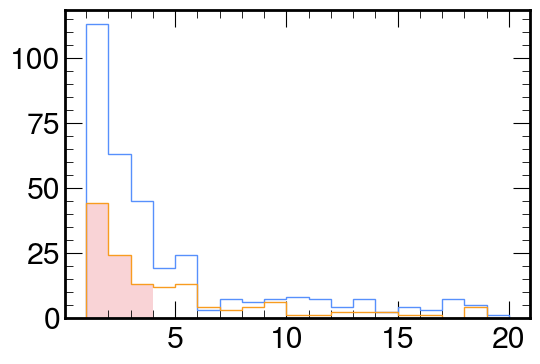

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(deltat, bins=19, range=(1, 20), histtype='step', label='Follower')
plt.hist(deltat_follower, bins=19, range=(1, 20), histtype='step', label='Follower');
plt.hist(deltat_follower_early, bins=19, range=(1,20),alpha=0.2)

In [17]:

def fit_decay_hist(data,bins=19,range=(0.5,20.5),tau_guess=2):

    bins=19

    counts, bin_edges = np.histogram(data, bins=bins, range=range)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    sigma = np.sqrt(counts)

    def decay_model(t, A, tau, B):
        return (A / tau) * np.exp(-t / tau) + B
    
    # Initial guess for the parameters
    A_guess = np.max(counts) * (range[1] - range[0]) / bins
    B_guess = np.min(counts)
    p0 = [A_guess, tau_guess, B_guess]

    popt, pcov = curve_fit(decay_model, bin_centers, counts, sigma=sigma, absolute_sigma=True, p0=p0, maxfev=100000) 

    A_fit, tau_fit, B_fit = popt
    A_err, tau_err, B_err = np.sqrt(np.diag(pcov))

    residuals = counts - decay_model(bin_centers, *popt)
    chi2 = np.sum((residuals / sigma) ** 2)
    dof = len(counts) - len(popt)
    chi2_red = chi2 / dof

    print("Fit results:")
    print(f"A = {A_fit:.3f} ± {A_err:.3f}")
    print(f"tau = {tau_fit:.3f} ± {tau_err:.3f}")
    print(f"B = {B_fit:.3f} ± {B_err:.3f}")
    print(f"Chi2 = {chi2:.3f}")
    print(f"Chi2/dof = {chi2_red:.3f}")

    plt.figure(figsize=(10, 6))
    plt.errorbar(bin_centers, counts, yerr=sigma, fmt='o', color='black', label='Data')
    t_fine = np.linspace(*range, 1000)
    plt.plot(t_fine, decay_model(t_fine, *popt), color='red', label=fr'WLS Fit: $\tau$ = {tau_fit:.3f} +/- {tau_err:.3f} µs')
    plt.xlabel('$\Delta$T (µs)', fontsize=20)
    plt.ylabel(f"Counts / {(range[-1]-range[0])/bins:.3f} µs",fontsize=20)
    plt.title(f" $\Delta$T = Time Since Last Prompt Trigger",fontsize=20)
    plt.grid(True)
    #plt.yscale('log')
    #plt.axvspan(0.5,3, color='blue', alpha=0.5, label='Selected Events')
    plt.legend(fontsize=15)
    plt.show()
    

#deltat_follower = [event.time_since_last_prompt_trigger_us for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<10]
fit_decay_hist(deltat_follower)



/home/bharris/.conda/envs/mypythonenv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:968: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/home/bharris/.conda/envs/mypythonenv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:538: RuntimeWarning: invalid value encountered in multiply
  return transform * (func(xdata, *params) - ydata)


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

In [18]:
total_digit_charge_pc = [event.total_digit_charge_pc for event in run.events if event.trigger_type!=None] 
total_log_charge_pc = [event.total_log_charge_pc for event in run.events if event.trigger_type!=None]
total_gaussian_charge_pc = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type!=None]

print(len(total_log_charge_pc),len(total_digit_charge_pc), len(total_gaussian_charge_pc))
print(total_digit_charge_pc[0])
print(total_log_charge_pc[0])
print(total_digit_charge_pc[0])

0 0 0


IndexError: list index out of range

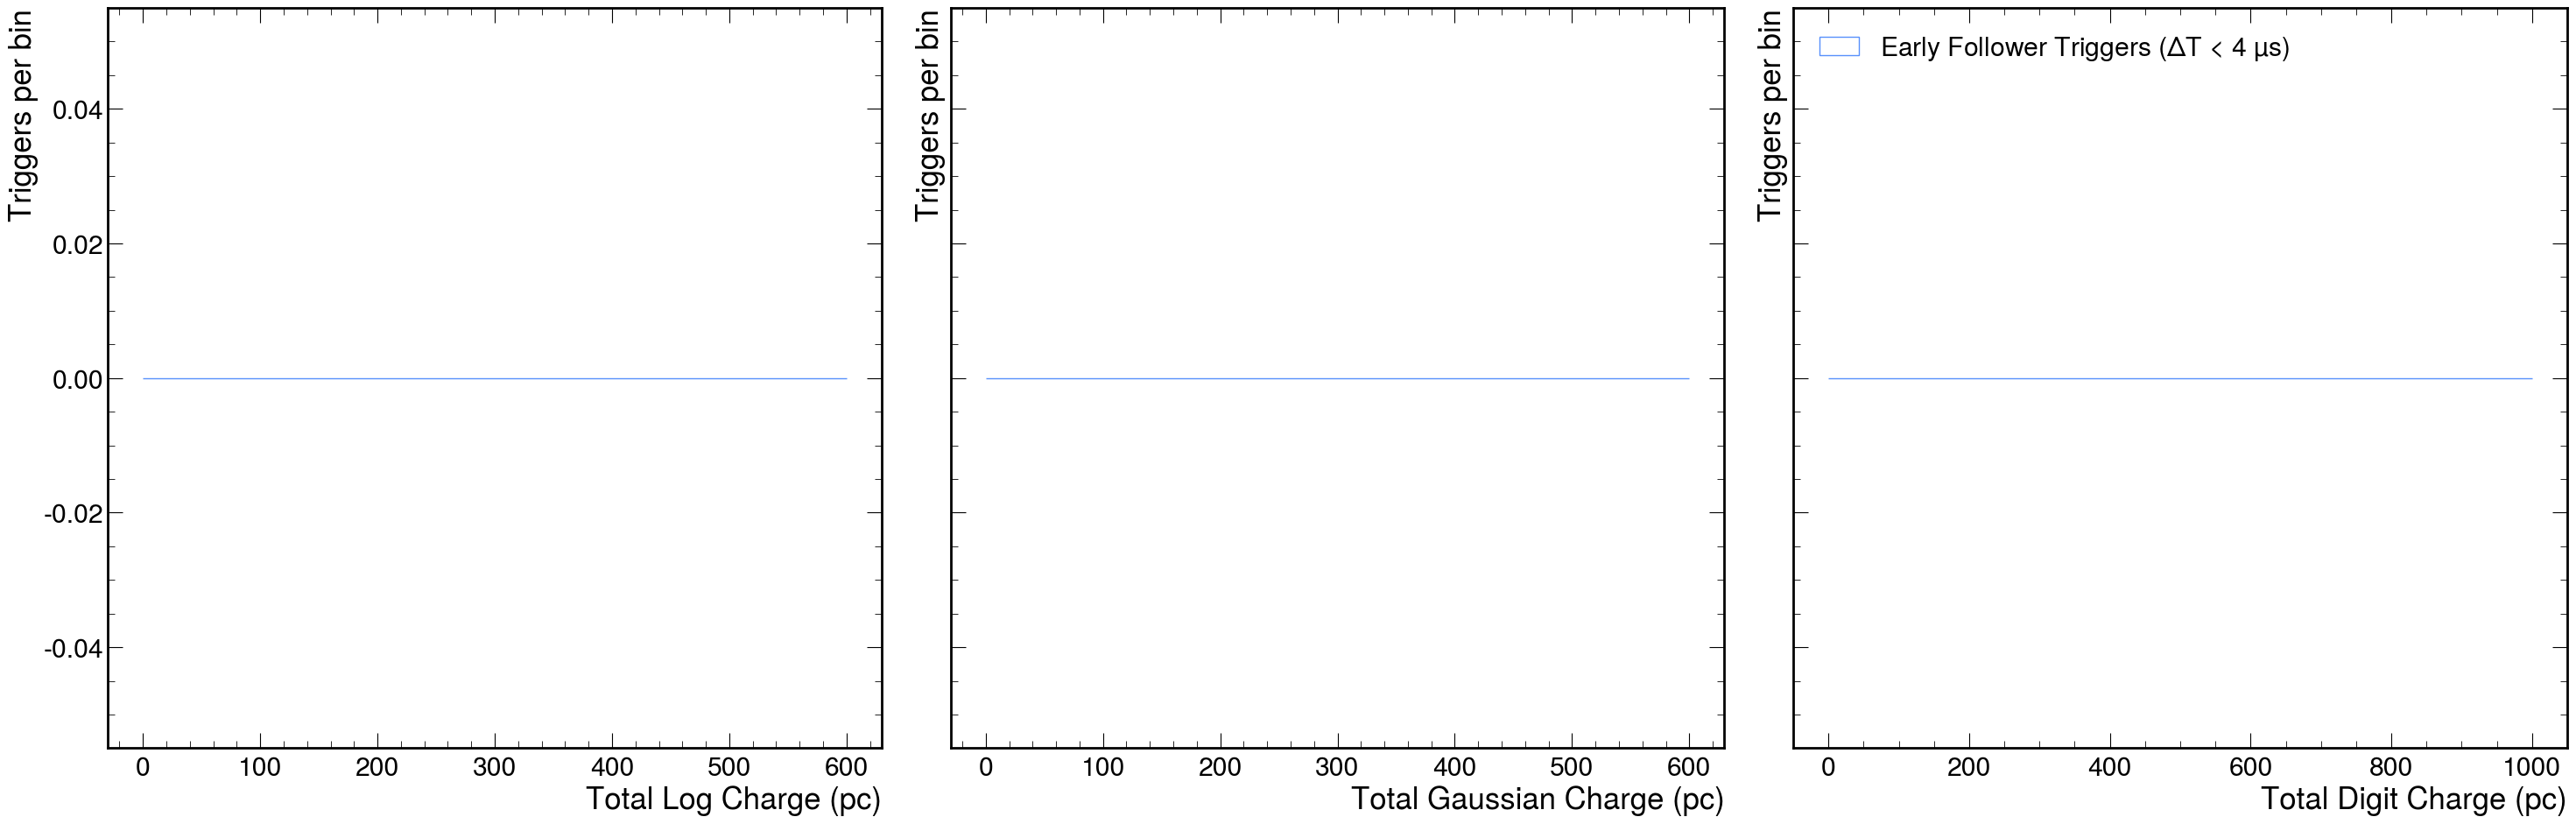

In [19]:
fig, ax = plt.subplots(1,3,figsize=(30, 10),sharey=True,tight_layout=True)
fontsize = 25
bins=150
upper_charge=1500
#log_bins = np.logspace(np.log10(1),np.log10(upper_charge), bins)

total_log_charge_pc_follower_early = [event.total_log_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4]
total_log_charge_pc_follower_late = [event.total_log_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us>4]
total_log_charge_pc_prompt = [event.total_log_charge_pc for event in run.events if event.trigger_type==0]

ax[0].hist(total_log_charge_pc_follower_early, bins=bins, range=(0,600), histtype='step', label='Early Follower Triggers ($\Delta$T < 4 µs)');
#ax[0].hist(total_log_charge_pc_follower_late, bins=bins, range=(0,upper_charge), histtype='step', label='Late Follower Triggers ($\Delta$T > 4 µs)');
#ax[0].hist(total_log_charge_pc_prompt, bins=bins, range=(0,upper_charge), histtype='step', label='All Prompt Triggers');
ax[0].set_xlabel('Total Log Charge (pc)', fontsize=fontsize)
ax[0].set_ylabel('Triggers per bin', fontsize=fontsize)
#ax[0].set_xscale('log')
#ax[0].set_yscale('log')
#ax[0].set_xlim(3e1,1e4)
#ax[0].legend()

total_gaussian_charge_pc_follower_early = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4]
total_gaussian_charge_pc_follower_late = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us>4]
total_gaussian_charge_pc_prompt = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type==0]

ax[1].hist(total_gaussian_charge_pc_follower_early, bins=bins, range=(0,600), histtype='step', label='Early Follower Triggers ($\Delta$T < 4 µs)');
#ax[1].hist(total_gaussian_charge_pc_follower_late, bins=bins, range=(0,upper_charge), histtype='step', label='Late Follower Triggers ($\Delta$T > 4 µs)');
#ax[1].hist(total_gaussian_charge_pc_prompt, bins=bins, range=(0,upper_charge), histtype='step', label='All Prompt Triggers');
ax[1].set_xlabel('Total Gaussian Charge (pc)', fontsize=fontsize)
ax[1].set_ylabel('Triggers per bin', fontsize=fontsize)
#ax[1].set_xscale('log')
#ax[1].set_yscale('log')
#ax[1].set_xlim(3e1,1e4)
#ax[1].legend()

total_digit_charge_pc_follower_early = [event.total_digit_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4]
total_digit_charge_pc_follower_late = [event.total_digit_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us>4]
total_digit_charge_pc_prompt = [event.total_digit_charge_pc for event in run.events if event.trigger_type==0]

ax[2].hist(total_digit_charge_pc_follower_early, bins=bins, range=(0,1000), histtype='step', label='Early Follower Triggers ($\Delta$T < 4 µs)');
#ax[2].hist(total_digit_charge_pc_follower_late, bins=bins, range=(0,upper_charge), histtype='step', label='Late Follower Triggers ($\Delta$T > 4 µs)');
#ax[2].hist(total_digit_charge_pc_prompt, bins=bins, range=(0,upper_charge), histtype='step', label='All Prompt Triggers');
ax[2].set_xlabel('Total Digit Charge (pc)', fontsize=fontsize)
ax[2].set_ylabel('Triggers per bin', fontsize=fontsize)
#ax[2].set_xlim(3e1,2e4)
#ax[2].set_xscale('log')
#ax[2].set_yscale('log')
ax[2].legend(loc='upper left')

In [20]:

digits = [event.digit_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us <4]

print(len(digits))
print(len(digits[3]),digits[0])
print(len(digits[2]),digits[1])

fds = digits[1]
print(fds)

import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np

# Assuming `fds` is your data
counts, bin_edges = np.histogram(fds, bins=15,range=(-5,10))

# Plot the histogram
plt.figure(figsize=(8, 8))
hep.histplot(counts, bins=bin_edges, color='blue', label='Digit Charges')
plt.xlabel('Digit Charge (pc)', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.title('Histogram of Digit Charges', fontsize=16)
plt.legend()
plt.show()
print(np.mean(fds))

0


IndexError: list index out of range

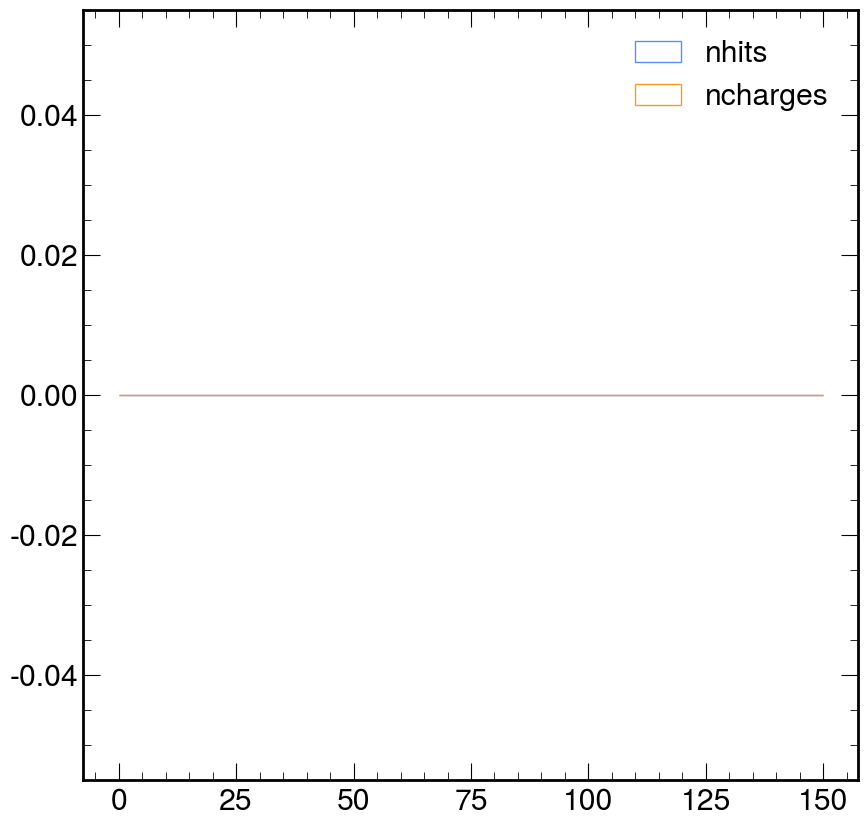

In [21]:
nhits = [event.nhits for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us < 4]
charges = [event.digit_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us < 4]

ncharges = []
for c in charges:
    ncharges.append(len(c))

plt.hist(nhits,bins=30,range=(0,150),histtype='step',label='nhits')
plt.hist(ncharges,bins=30,range=(0,150),histtype='step',label='ncharges')
plt.legend()

/tmp/ipykernel_2808082/514528467.py:14: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


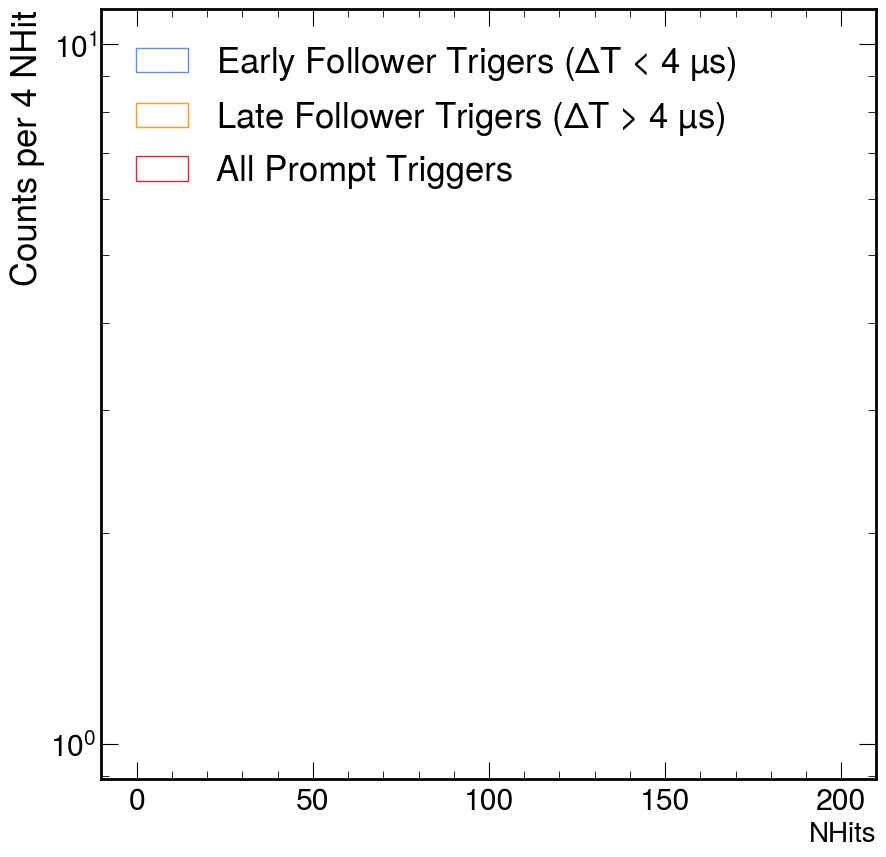

In [22]:

nhit_follower_early = [event.nhits for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4]
nhit_follower_late = [event.nhits for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us>4]
#nhit_follower_wierd = [event.nhits for event in run.events if event.trigger_type==1 and 8>event.time_since_last_prompt_trigger_us>3]
nhit_prompt = [event.nhits for event in run.events if event.trigger_type==0]

#plt.hist(total_log_charge_pc_follower, bins=50, range=(0,500), histtype='step', label='Follower');
plt.hist(nhit_follower_early, bins=50, range=(0,200), histtype='step', label='Early Follower Trigers ($\Delta$T < 4 µs)');
plt.hist(nhit_follower_late, bins=50, range=(0,200), histtype='step', label='Late Follower Trigers ($\Delta$T > 4 µs)');
#plt.hist(nhit_follower_wierd, bins=50, range=(0,200), histtype='step', label='Follower Wierd');
plt.hist(nhit_prompt, bins=50, range=(0,200), histtype='step', label='All Prompt Triggers');
plt.xlabel('NHits', fontsize=20)
plt.ylabel('Counts per 4 NHit', fontsize=fontsize)
plt.legend(loc='upper left',fontsize=fontsize)
plt.yscale('log')

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
        0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
        0.77, 0.78, 0.79, 0.8 , 

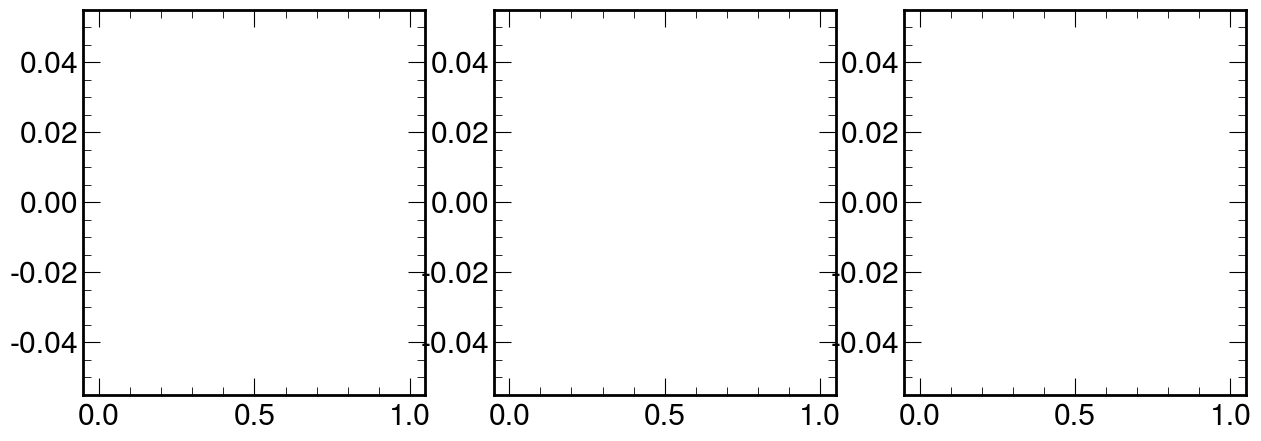

In [23]:
xquad = [event.xquad for event in run.events if event.xquad > -5000]
yquad = [event.yquad for event in run.events if event.yquad > -5000]
zquad = [event.zquad for event in run.events if event.zquad > -5000]


fig,ax=plt.subplots(1,3,figsize=(15,5))
ax[0].hist(xquad,bins=100)
ax[1].hist(yquad,bins=100)
ax[2].hist(zquad,bins=100)

In [98]:

# grouped_hit_times = {}

# for event in run.events:
#     for pmt_id, time in zip(event.digit_pmt_id, event.digit_time_ns):
#         if True: #run.pmt_is_online[pmt_id]:#and -30<time<10:
#             group = pmt_id // 16
#             if group not in grouped_hit_times:
#                 grouped_hit_times[group] = []
#             grouped_hit_times[group].append(time)

# # Convert to NumPy array if needed
# for group in grouped_hit_times:
#     grouped_hit_times[group] = np.array(grouped_hit_times[group])

# plt.figure(figsize=(10, 10))

# colors = plt.cm.tab10.colors  # color palette
# for i, (group, times) in enumerate(sorted(grouped_hit_times.items())):
#     plt.hist(times, bins=200, range=(-200,200), histtype='step', label=f'PMTs {group*16}-{group*16+15}', color=colors[i % len(colors)])

# plt.xlabel('Hit Time')
# plt.ylabel('Counts')
# #plt.legend()
# plt.title('Hit Time Distribution by 16-Channel PMT Group')
# plt.tight_layout()

# print(f"{len(grouped_hit_times)+1} groups")


# plt.show()




In [99]:

# group_to_plot = 0  # Change this to whichever group you want

# if group_to_plot in grouped_hit_times:
#     plt.figure(figsize=(8, 6))
#     times = grouped_hit_times[group_to_plot]
#     plt.hist(times, bins=200, range=(-200, 200), histtype='step', 
#              label=f'PMTs {group_to_plot*16}-{group_to_plot*16+15}',
#              color='tab:blue')
    
#     plt.xlabel('Hit Time (ns)')
#     plt.ylabel('Counts')
#     plt.title(f'Hit Time Distribution for PMT Group {group_to_plot}')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()
# else:
#     print(f"Group {group_to_plot} not found in data.")


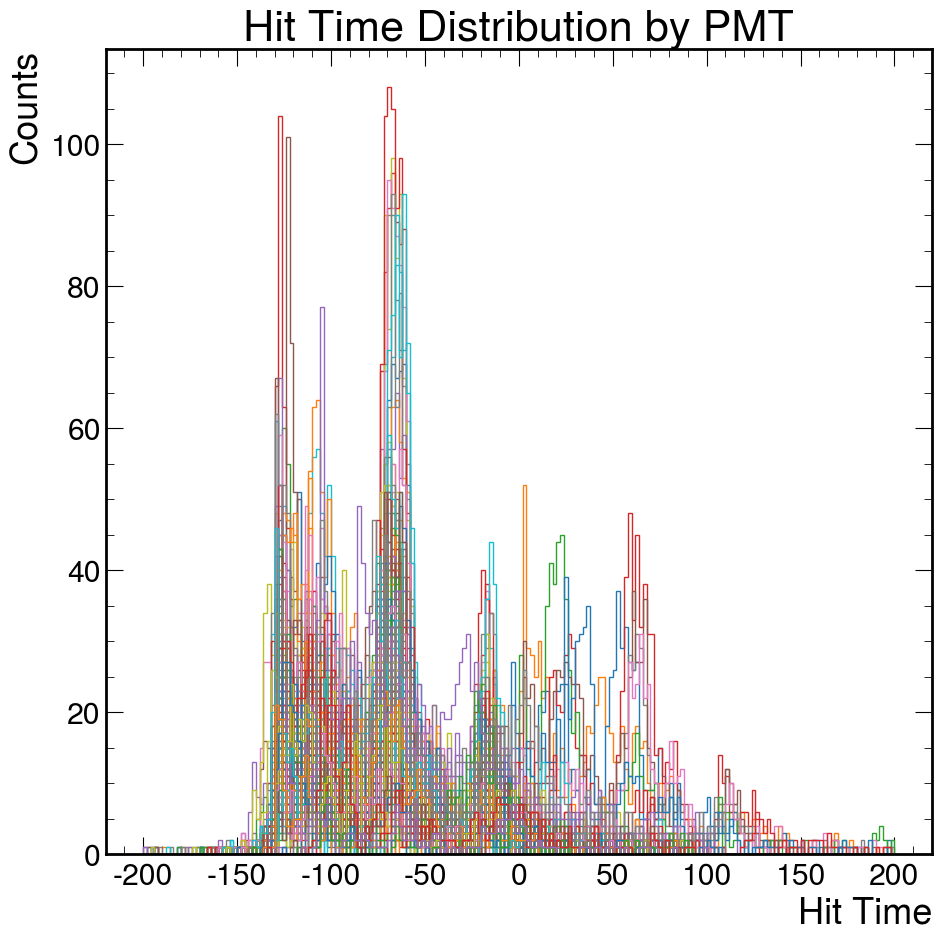

In [253]:

michels = [event for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4]
channel_hit_times = {}

for event in michels:
    for pmt_id, time in zip(event.digit_pmt_id, event.digit_time_ns):
        # Can do sorting here. Should really put back into class
        if True:#-500<event.xquad<500 and -500<event.yquad<500 and -500<event.zquad<500:
            channel = pmt_id 
            if channel not in channel_hit_times:
                channel_hit_times[channel] = []
            channel_hit_times[channel].append(time)

# Convert to NumPy array if needed
for channel in channel_hit_times:
    channel_hit_times[channel] = np.array(channel_hit_times[channel])

plt.figure(figsize=(10, 10))

colors = plt.cm.tab10.colors  # color palette
for i, (channel, times) in enumerate(sorted(channel_hit_times.items())):
    plt.hist(times, bins=200, range=(-200,200), histtype='step', label=f'PMTs {channel}', color=colors[i % len(colors)])

plt.xlabel('Hit Time')
plt.ylabel('Counts')
#plt.legend()
plt.title('Hit Time Distribution by PMT')
plt.tight_layout()
plt.show()




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


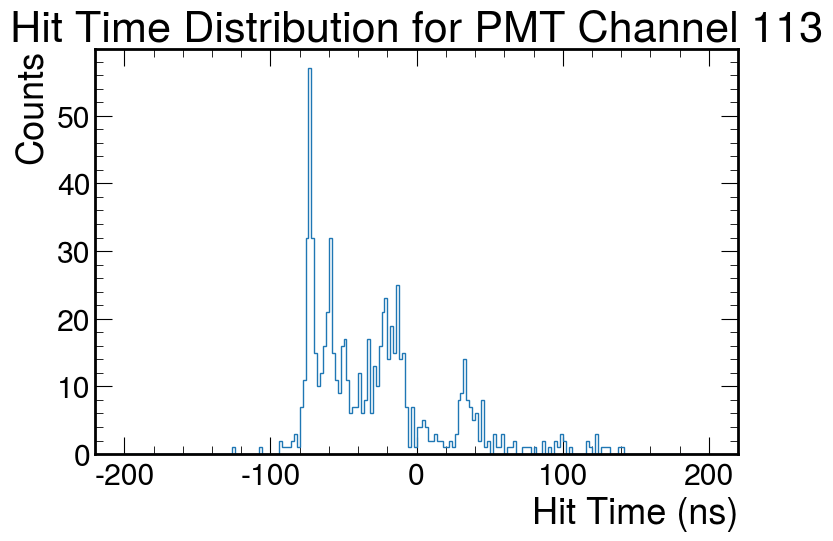

In [254]:
id2ch = dict(zip(run.pmt_id, run.pmt_ch))

channel_to_plot = 4 # Change this to whichever group you want

if channel_to_plot in channel_hit_times:
    plt.figure(figsize=(8, 6))
    times = channel_hit_times[channel_to_plot]
    plt.hist(times, bins=200, range=(-200, 200), histtype='step',
             color='tab:blue')
    
    plt.xlabel('Hit Time (ns)')
    plt.ylabel('Counts')
    plt.title(f'Hit Time Distribution for PMT Channel {id2ch[channel_to_plot]}')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"Group {channel_to_plot} not found in data.")

In [255]:
# print(len(grouped_hit_times))
# print(len(run.pmt_is_online[run.pmt_is_online==True]))

# Looks like 2 more pmts turned off. Should recreate online list to feed into sim
# and not make any assumptions



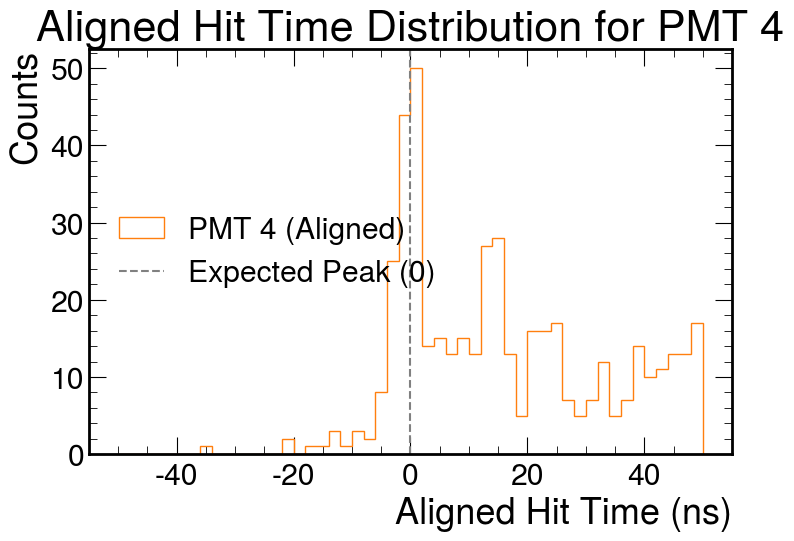

In [256]:
cable_delays = {}  # Dictionary to store delay per PMT
aligned_channel_hit_times = {}  # Store corrected hit times

def compute_cable_delays(channel_hit_times, bins=200, range=(-200, 200)):
    for pmt_id, times in channel_hit_times.items():
        # Compute histogram
        counts, bin_edges = np.histogram(times, bins=bins, range=range)
        
        # Find the bin with the max count
        max_bin_index = np.argmax(counts)
        
        # Compute the center of that bin
        bin_center = 0.5 * (bin_edges[max_bin_index] + bin_edges[max_bin_index + 1])
        
        # Store delay
        cable_delays[pmt_id] = bin_center
        
        # Apply delay correction to hit times
        aligned_channel_hit_times[pmt_id] = times - bin_center

    return cable_delays

compute_cable_delays(channel_hit_times)

# Plot an aligned histogram to verify peak is at 0
def plot_aligned_channel(pmt_id):
    if pmt_id in aligned_channel_hit_times:
        plt.figure(figsize=(8, 6))
        times = aligned_channel_hit_times[pmt_id]
        plt.hist(times, bins=50, range=(-50, 50), histtype='step', 
                 label=f'PMT {pmt_id} (Aligned)', color='tab:orange')
        plt.xlabel('Aligned Hit Time (ns)')
        plt.ylabel('Counts')
        plt.title(f'Aligned Hit Time Distribution for PMT {pmt_id}')
        plt.axvline(0, color='gray', linestyle='--', label='Expected Peak (0)')
        plt.legend()
        plt.tight_layout()
        # plt.yscale('log')
        plt.show()
    else:
        print(f"PMT {pmt_id} not found in aligned data.")

# Try it
plot_aligned_channel(4)




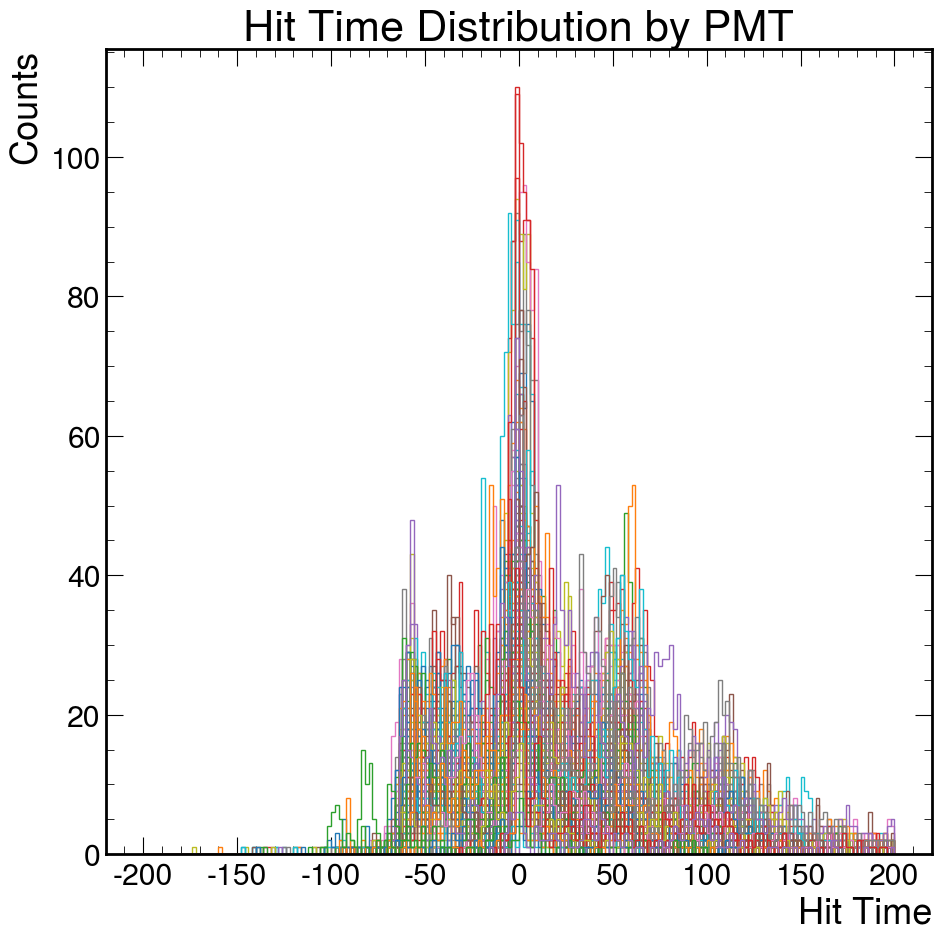

In [257]:
plt.figure(figsize=(10,10))
colors = plt.cm.tab10.colors  # color palette
for i, (channel, times) in enumerate(sorted(aligned_channel_hit_times.items())):
    plt.hist(times, bins=200, range=(-200,200), histtype='step', label=f'PMTs {channel}', color=colors[i % len(colors)])

plt.xlabel('Hit Time')
plt.ylabel('Counts')
#plt.legend()
plt.title('Hit Time Distribution by PMT')
plt.tight_layout()
# plt.yscale('log')
plt.show()



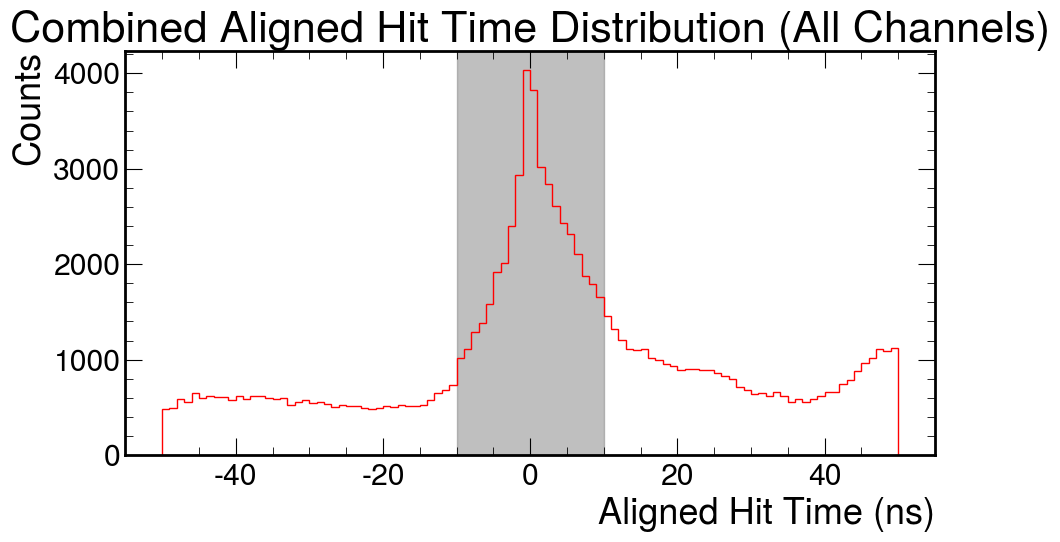

In [258]:
# Combine all aligned times into one array
all_aligned_times = np.concatenate(list(aligned_channel_hit_times.values()))

# Plot the combined histogram
plt.figure(figsize=(10, 6))
plt.hist(all_aligned_times, bins=100, range=(-50, 50), histtype='step', edgecolor='red')
plt.axvspan(-10,10,color='grey',alpha=0.5)
plt.xlabel('Aligned Hit Time (ns)')
plt.ylabel('Counts')
plt.title('Combined Aligned Hit Time Distribution (All Channels)')
plt.tight_layout()
plt.show()



In [259]:

# Define PMT channels
barrel_boards = [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11]
barrel_channels = [16 * board + i for board in barrel_boards for i in range(16)]


special_channels = np.arange(0, 36, 1)

top_boards =  [12, 13]
top_channels = [16 * board + i for board in top_boards for i in range(16)]

dichroic_boards = [7]
dichroic_channels = [16 * board + i for board in dichroic_boards for i in range(16)]

bottom_boards = [14, 15]
bottom_channels = [16 * board + i for board in bottom_boards for i in range(16)]

behind_boards = [16]
behind_channels = [16 * board + i for board in behind_boards for i in range(13)]

# Create channel to ID mapping
ch2id = dict(zip(run.pmt_ch, run.pmt_id))

# Convert channel lists to ID lists
barrel_ids = [ch2id[ch] for ch in barrel_channels if ch in ch2id]
bottom_ids = [ch2id[ch] for ch in bottom_channels if ch in ch2id]
dichroic_ids = [ch2id[ch] for ch in dichroic_channels if ch in ch2id]
special_ids = [ch2id[ch] for ch in special_channels if ch in ch2id]
top_ids = [ch2id[ch] for ch in top_channels if ch in ch2id]
behind_ids = [ch2id[ch] for ch in behind_channels if ch in ch2id]


268


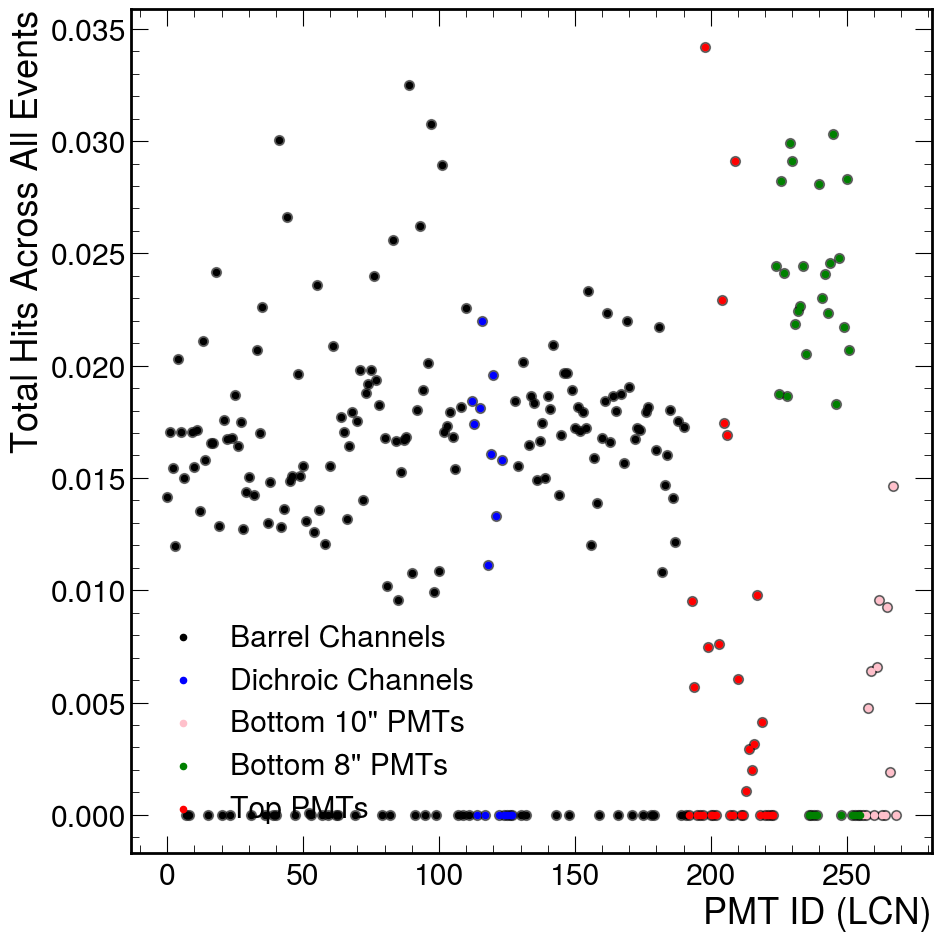

In [260]:
pmt_id_to_ch = dict(zip(run.pmt_id, run.pmt_ch))

# Assuming each PMT ID maps directly to its LCN (i.e., pmt_id == lcn)
pmt_hit_counts = np.zeros(np.max(run.pmt_ch)+1, dtype=int)

# Count hits for online PMTs
for i, (pmt_id, times) in enumerate(sorted(aligned_channel_hit_times.items())):
    cut_times = []
    for time in times:
        if True:#-10<time<10:
            pmt_hit_counts[pmt_id_to_ch[pmt_id]] += 1

print(np.max(run.pmt_ch))

coinc_hit_counts = pmt_hit_counts / len(run.events)

# Plot
plt.figure(figsize=(10, 10))
plt.scatter(range(len(pmt_hit_counts)), coinc_hit_counts, s=50, alpha=0.5, color='black')

# Optional: highlight barrel and dichroic
plt.scatter(barrel_channels, coinc_hit_counts[barrel_channels], s=20, alpha=1, color='black', label='Barrel Channels')
plt.scatter(dichroic_channels, coinc_hit_counts[dichroic_channels], s=20, alpha=1, color='blue', label='Dichroic Channels')
plt.scatter(behind_channels, coinc_hit_counts[behind_channels], s=20, alpha=1, color='pink', label='Bottom 10" PMTs')
plt.scatter(bottom_channels, coinc_hit_counts[bottom_channels], s=20, alpha=1, color='green', label='Bottom 8" PMTs')
plt.scatter(top_channels, coinc_hit_counts[top_channels], s=20, alpha=1, color='red', label='Top PMTs')

plt.xlabel("PMT ID (LCN)")
plt.ylabel("Total Hits Across All Events")
plt.legend(loc='lower left')
#plt.ylim(np.max(pmt_hit_counts)/2,2*np.max(pmt_hit_counts))
plt.tight_layout()


Dichroic avg: 0.325 ± 0.001 hits/event
Bottom 8" avg: 0.405 ± 0.001 hits/event
Ratio (dichroic/bottom): 0.80 ± 0.00


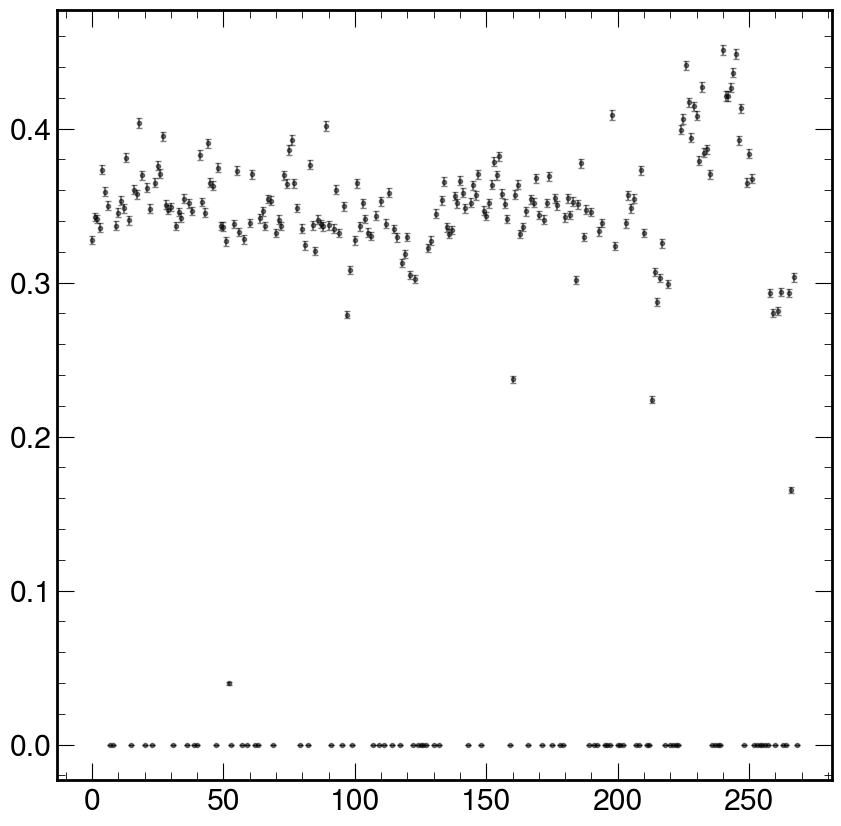

In [251]:
import numpy as np
from uncertainties import ufloat  # Requires `uncertainties` package (pip install uncertainties)

# Convert hit counts to rates and propagate Poisson errors
pmt_hit_rates = []
pmt_hit_errors = []

for count in pmt_hit_counts:
    # For each PMT: rate = count / N_events, with uncertainty √count / N_events
    N_events = len(run.events)
    rate = count / N_events
    error = np.sqrt(count) / N_events  # Poisson error propagation
    pmt_hit_rates.append(rate)
    pmt_hit_errors.append(error)

# Convert to numpy arrays
pmt_hit_rates = np.array(pmt_hit_rates)
pmt_hit_errors = np.array(pmt_hit_errors)

# Plot with error bars
plt.errorbar(
    x=np.arange(len(pmt_hit_rates)),
    y=pmt_hit_rates,
    yerr=pmt_hit_errors,
    fmt='o',
    markersize=3,
    capsize=2,
    alpha=0.5,
    color='black',
    label='PMT hit rates ± 1σ'
)

def weighted_average_with_uncertainty(rates, errors):
    """Calculate weighted average and its uncertainty."""
    weights = 1 / (errors ** 2)
    avg = np.sum(weights * rates) / np.sum(weights)
    err = 1 / np.sqrt(np.sum(weights))
    return avg, err

# Dichroic channels
dichroic_rates = pmt_hit_rates[dichroic_channels]
dichroic_errors = pmt_hit_errors[dichroic_channels]
avg_dichroic, err_dichroic = weighted_average_with_uncertainty(
    dichroic_rates[dichroic_rates > 0.1],
    dichroic_errors[dichroic_rates > 0.1]
)

# Bottom 8" channels
bottom_rates = pmt_hit_rates[bottom_channels]
bottom_errors = pmt_hit_errors[bottom_channels]
avg_bottom, err_bottom = weighted_average_with_uncertainty(
    bottom_rates[bottom_rates > 0.1],
    bottom_errors[bottom_rates > 0.1]
)

print(f"Dichroic avg: {avg_dichroic:.3f} ± {err_dichroic:.3f} hits/event")
print(f"Bottom 8\" avg: {avg_bottom:.3f} ± {err_bottom:.3f} hits/event")

R = avg_dichroic / avg_bottom
R_err = R * np.sqrt((err_dichroic/avg_dichroic)**2 + (err_bottom/avg_bottom)**2)

print(f"Ratio (dichroic/bottom): {R:.2f} ± {R_err:.2f}")


[-22.6, -20, 30.8, -17, -19.7, 7.19, ..., -26.9, -13.9, 46.9, -8.3, -27.6]


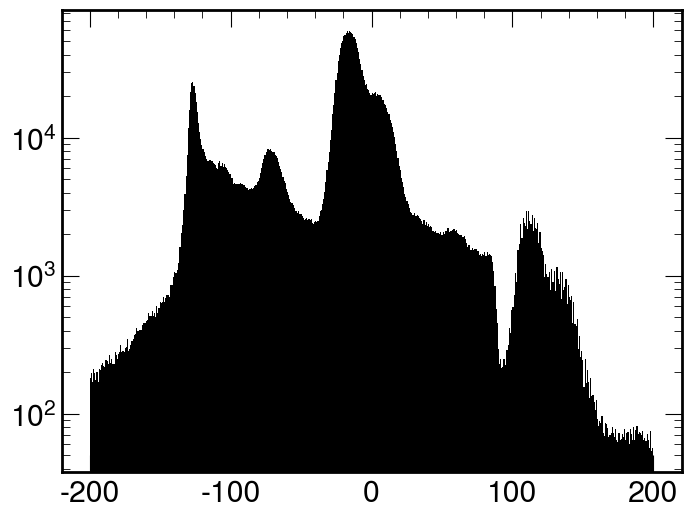

In [238]:



times = [event.digit_time_ns for event in run.events]
print(times[0])

plt.figure(figsize=(8, 6))


times = ak.flatten(times) 


plt.hist(times, color='black', bins=500, range=(-200,200), label='Michel Candidates')
plt.yscale('log')

In [179]:
# Now do cuts

# Timing (cable delays???? dichroicon board  may be wack)
# I think individual channels are wack - cant just look at board
# Yep, need to do individual cable delays!!

# position (fiducial?)

# normalize relative to bottom pmts

# do as a function of reco z (need updated EosSims - finish other shit!)

# am I really simualting what I am selecting from real events????

# ****** why are boards 0-50 inverted? *****

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7691f7267e20>, cbar=<matplotlib.colorbar.Colorbar object at 0x7691f7209400>, text=[])

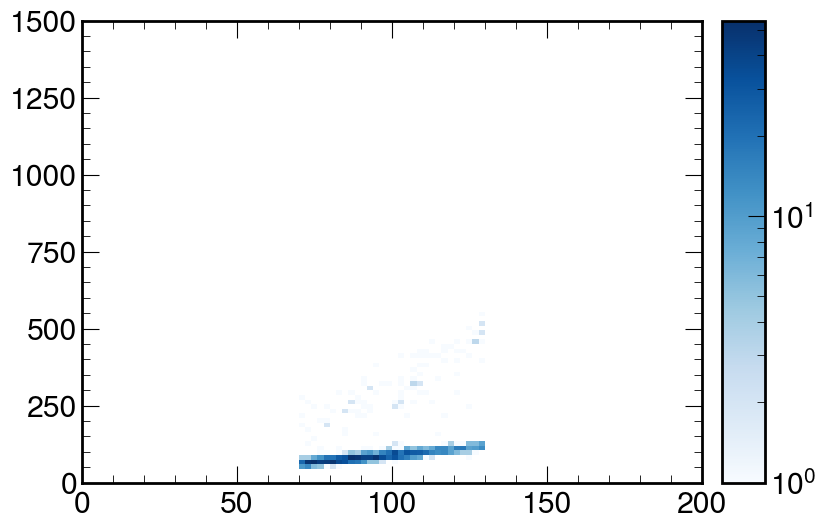

In [154]:

plt.figure(figsize=(8, 6))
hep.hist2dplot(np.histogram2d(nhit_follower_early, total_gaussian_charge_pc_follower_early, bins=(100, 100), range=((0, 200), (0, 1500))), cmap='Blues', norm='log')

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x769235ebe670>, cbar=<matplotlib.colorbar.Colorbar object at 0x7691f71ea340>, text=[])

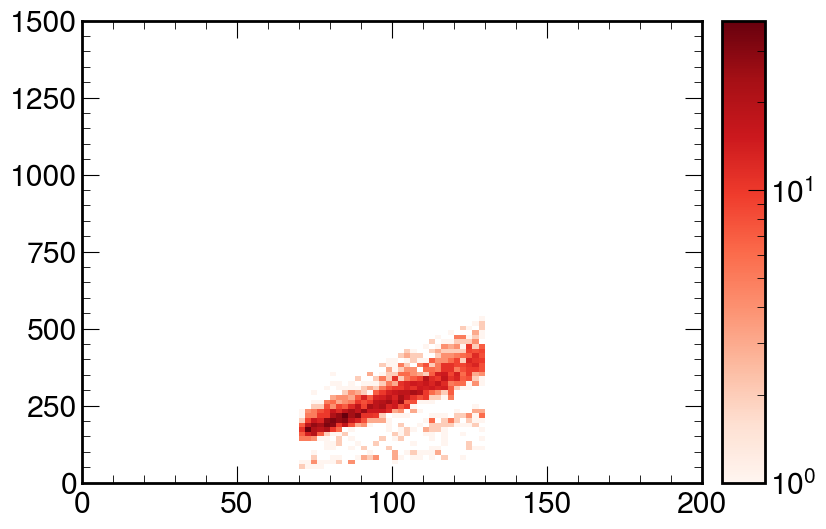

In [155]:
plt.figure(figsize=(8, 6))
hep.hist2dplot(np.histogram2d(nhit_follower_late, total_gaussian_charge_pc_follower_late, bins=(100, 100), range=((0, 200), (0, 1500))), cmap='Reds', norm='log')

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x769007f76280>, cbar=<matplotlib.colorbar.Colorbar object at 0x769007f76790>, text=[])

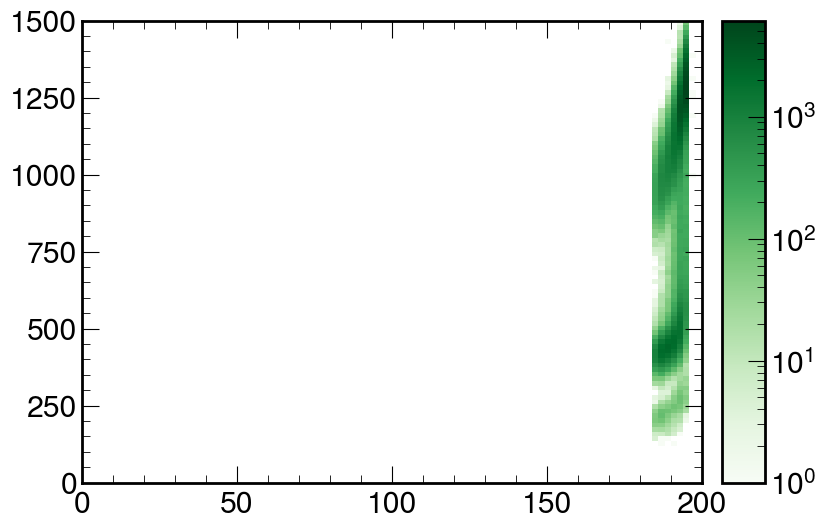

In [ ]:
plt.figure(figsize=(8, 6))
hep.hist2dplot(np.histogram2d(nhit_prompt, total_gaussian_charge_pc_prompt, bins=(100, 100), range=((0, 200), (0, 1500))), cmap='Greens', norm='log')


Text(22.58333333333333, 1, 'Total Charge per Trigger (pc)')

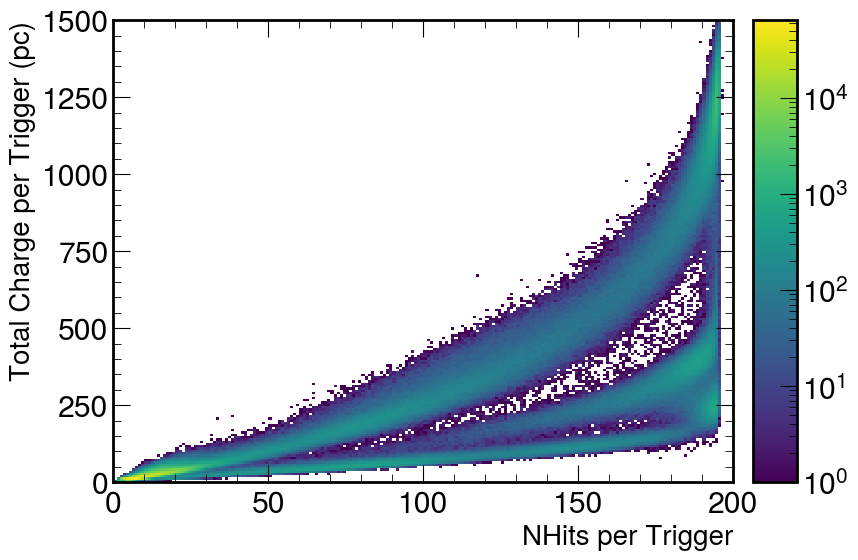

In [ ]:
nhits = [event.nhits for event in run.events]
charges = [event.total_log_charge_pc for event in run.events]

charge_log_bins = np.logspace(np.log10(2),np.log10(1500), bins)
nhit_log_bins = np.logspace(np.log10(2),np.log10(200), bins)

plt.figure(figsize=(8, 6))
hep.hist2dplot(np.histogram2d(nhits, charges, bins=(200, 200), range=((0, 200), (0, 1500))), norm='log')
plt.xlabel('NHits per Trigger', fontsize=20)
plt.ylabel('Total Charge per Trigger (pc)', fontsize=20)

Fit results:
A = 51379.098 ± 1438.727
tau = 2.108 ± 0.074
B = 342.327 ± 11.285
Chi2 = 2.010
Chi2/dof = 1.005


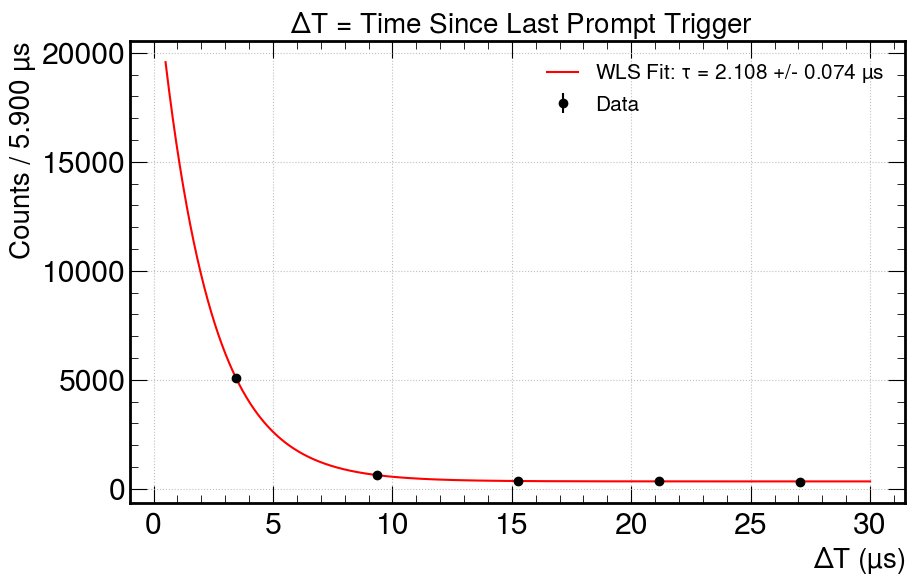

Fit results:
A = 1640621.290 ± 3020265.434
tau = 537.013 ± 638.361
B = 906.501 ± 2285.854
Chi2 = 0.480
Chi2/dof = 0.240


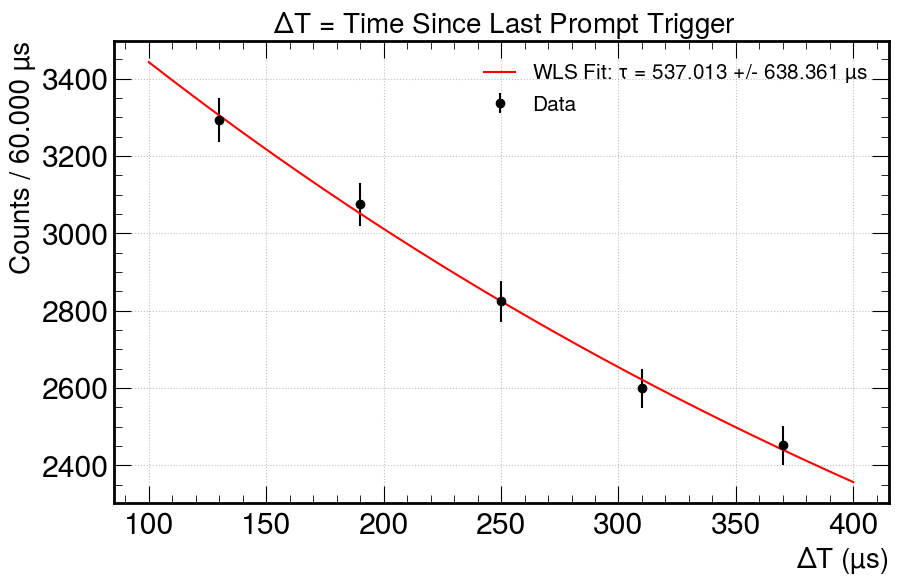

In [ ]:
early_follower_times = [event.time_since_last_prompt_trigger_us for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<30]
late_follower_times = [event.time_since_last_prompt_trigger_us for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us>30]


fit_decay_hist(early_follower_times,bins=29,range=(0.5,30),tau_guess=2)
fit_decay_hist(late_follower_times,bins=30,range=(100,400),tau_guess=200)

Text(14.33333333333333, 1, 'Total Charge per Trigger (pc)')

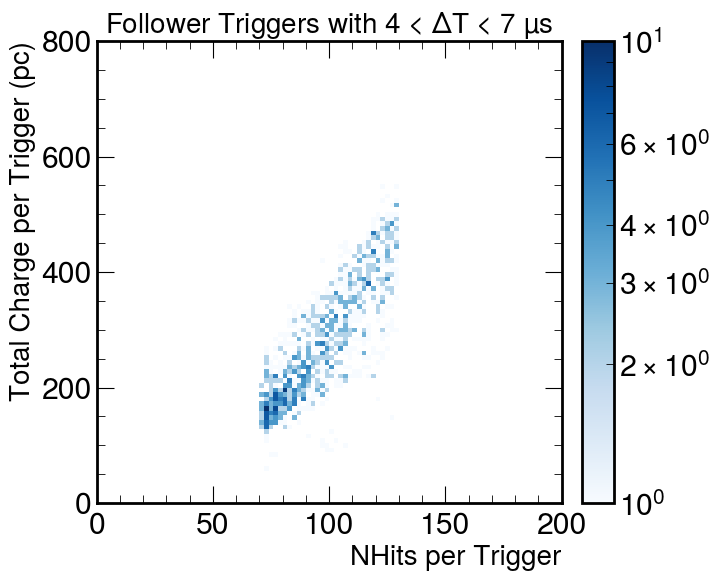

In [ ]:
nhits = [event.nhits for event in run.events if event.trigger_type==1 and 4<event.time_since_last_prompt_trigger_us<7]
charges = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type==1 and 4<event.time_since_last_prompt_trigger_us<7]
plt.figure(figsize=(6, 6))
hep.hist2dplot(np.histogram2d(nhits, charges, bins=(100, 100), range=((0, 200), (0, 800))), cmap='Blues', norm='log')
plt.title("Follower Triggers with 4 < $\Delta$T < 7 µs", fontsize=20)
plt.xlabel('NHits per Trigger', fontsize=20)
plt.ylabel('Total Charge per Trigger (pc)', fontsize=20)

Text(14.33333333333333, 1, 'Total Charge per Trigger (pc)')

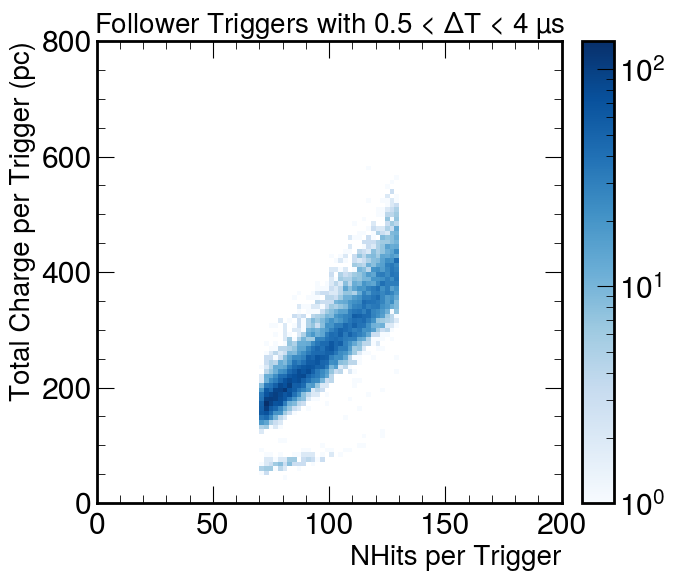

In [ ]:
nhits = [event.nhits for event in run.events if event.trigger_type==1 and 100<event.time_since_last_prompt_trigger_us<400]
charges = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type==1 and 100<event.time_since_last_prompt_trigger_us<400]
plt.figure(figsize=(6, 6))
hep.hist2dplot(np.histogram2d(nhits, charges, bins=(100, 100), range=((0, 200), (0, 800))), cmap='Blues', norm='log')
plt.title("Follower Triggers with 0.5 < $\Delta$T < 4 µs", fontsize=20)
plt.xlabel('NHits per Trigger', fontsize=20)
plt.ylabel('Total Charge per Trigger (pc)', fontsize=20)